# ЛР3. Классификация с помощью дерева принятия решений.

In [2]:
!pip install googledrivedownloader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 KB 480.3 kB/s eta 0:00:0031m1.0 MB/s eta 0:00:01


In [16]:
import numpy as np
import pandas as pd

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.datasets import load_iris

import matplotlib.pyplot as plt

from google_drive_downloader import GoogleDriveDownloader as gdd

## Задание 1.

Для каждого из подзаданий: 

1. Постройте модель классификации на основе дерева принятия решений.
2. Подберите оптимальные гиперпараметры модели используя кросс-валидацию.
3. Визуализируйте деревья для моделей.
4. Протестируйте различные метрики оценки качества разбиения (Джини, Энтропия). 
5. Сделайте выводы о точности моделей.


### 1.1 Скоринг отказа от услуг оператора связи.

Используйте данные из файла telecom.csv для предсказания отказа от услуг связи. Столбец "churn". 
Предврительно изучите и подготовьте данные.

In [6]:
gdd.download_file_from_google_drive(file_id='1KMOOvHfoltYupUsaS9nD2ltF2tkPrKze',
                                dest_path='./data/telecom.csv')

In [7]:
df =  pd.read_csv('./data/telecom.csv')

df

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,414-4276,no,yes,36,156.2,77,26.55,...,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
3329,WV,68,415,370-3271,no,no,0,231.1,57,39.29,...,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
3330,RI,28,510,328-8230,no,no,0,180.8,109,30.74,...,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
3331,CT,184,510,364-6381,yes,no,0,213.8,105,36.35,...,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False


In [8]:
cat_columns = ['state','international plan','voice mail plan']
num_columns = [col for col in df.columns if col not in cat_columns+['churn', 'phone number']]


num_proc = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

cat_proc = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore"),
)

preprocessor = make_column_transformer(
    (num_proc, num_columns), (cat_proc, cat_columns)
)

clf = DecisionTreeClassifier()

In [9]:
X, y = df.drop(['churn'], axis=1), df['churn']
X = preprocessor.fit_transform(df)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [10]:
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [11]:
y_pred = clf.predict(X_test)

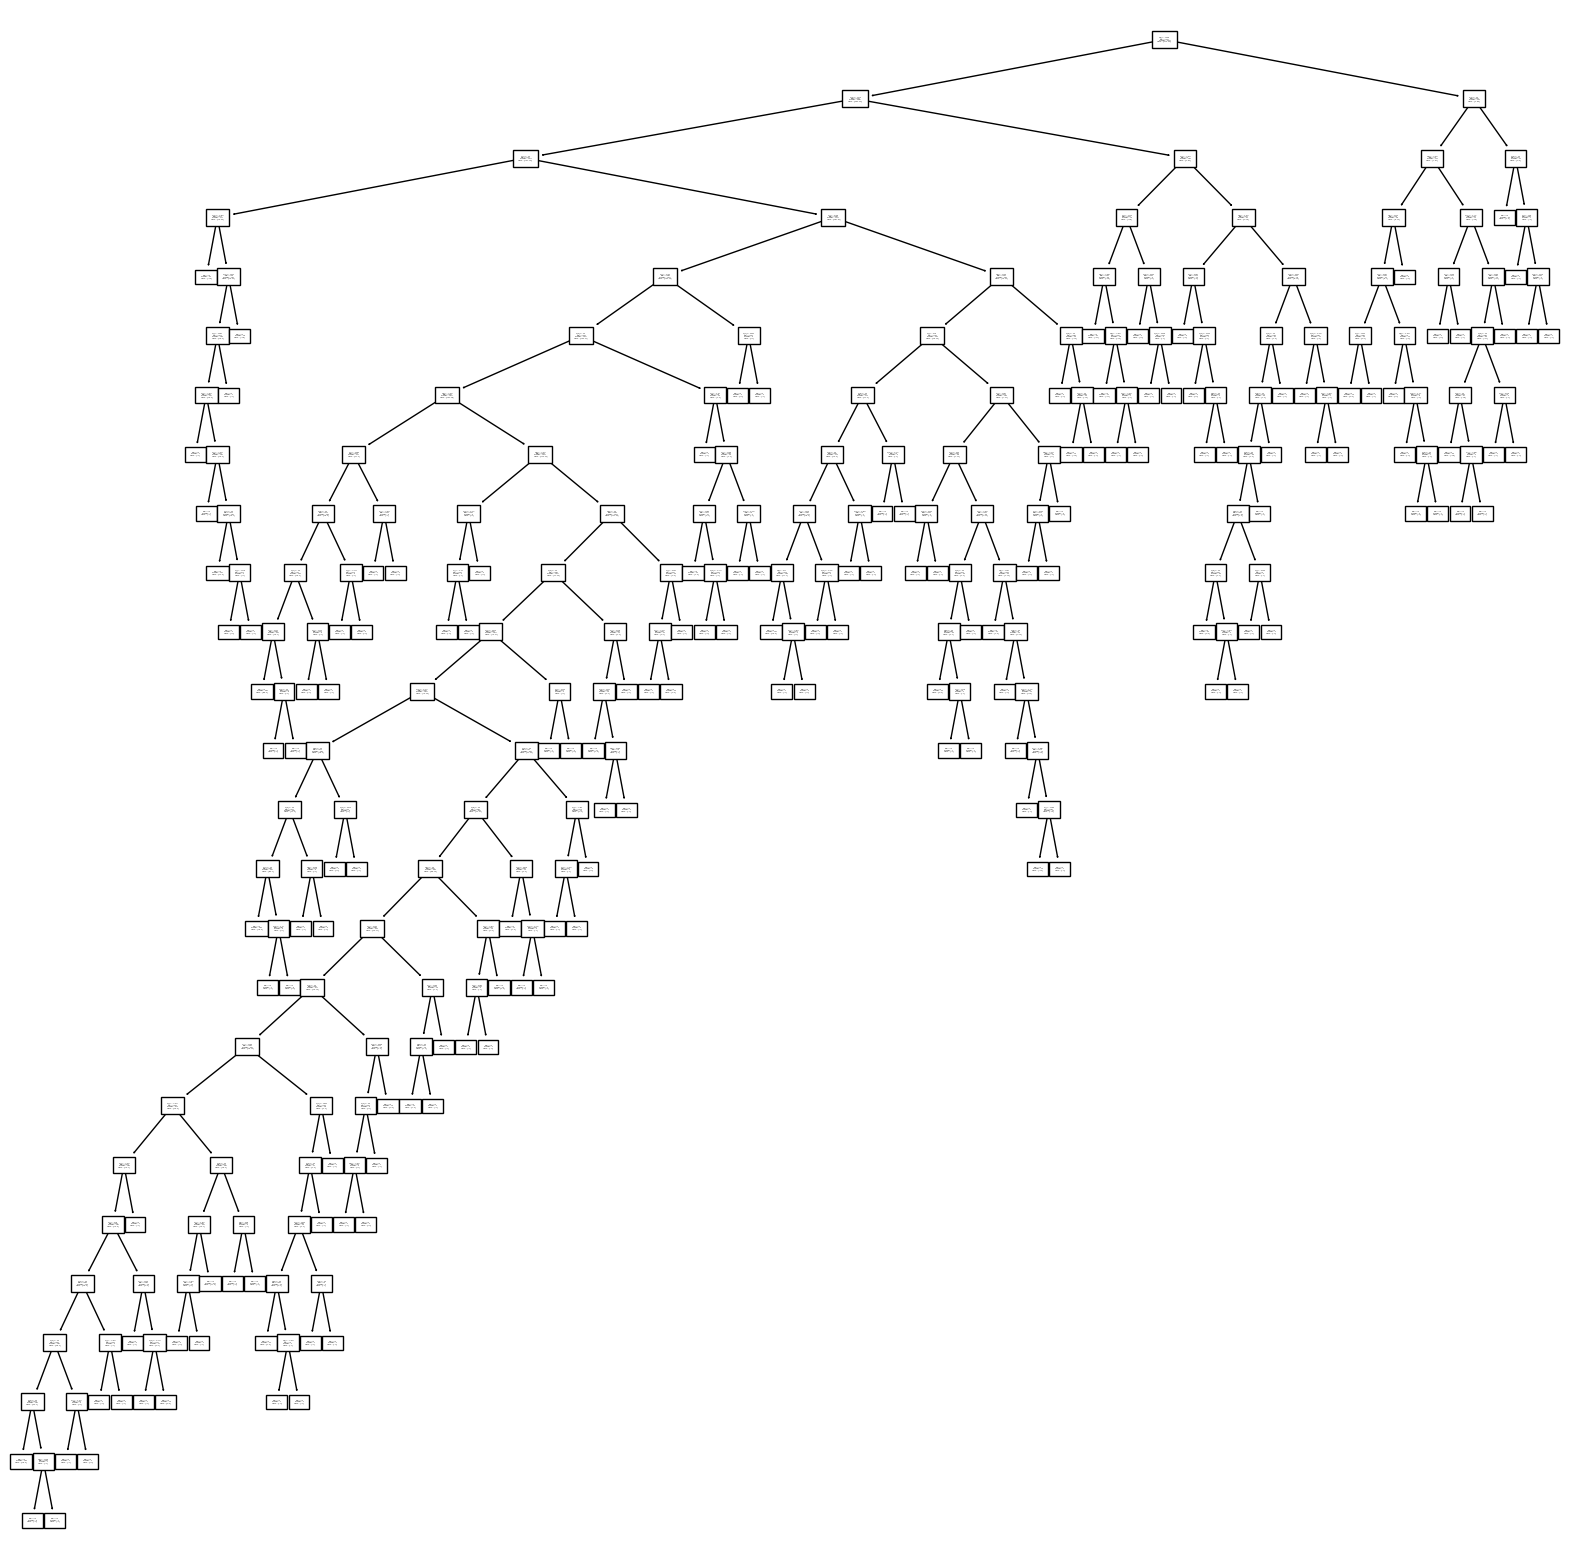

In [21]:
fig, ax = plt.subplots(figsize=(20, 20))

plot_tree(clf, fontsize=1, ax=ax)
plt.show()

In [ ]:
roc_auc_score(y_pred, y_test)

In [ ]:
param_grid = [
    {'criterion': ['entropy', 'gini']},
    {'splitter' : ['best', 'random']},
    {'max_depth': np.arange(1, 30)},
    {'min_samples_leaf':  np.arange(1, 30)}
]

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=0)

search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring="roc_auc", cv=cv)
search.fit(X_train, y_train)

In [ ]:
search.best_params_

In [ ]:
y_pred = search.predict(X_test)

In [ ]:
roc_auc_score(y_pred, y_test)

### 1.2 Классификация ириса из датасет iris. 

Предскажите вид ириса по его параметрам.

In [ ]:
iris = load_iris()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.33, random_state=42)

In [ ]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
plot_tree(clf, filled=True)

In [ ]:
y_pred = clf.predict_proba(X_test)

In [ ]:
roc_auc_score(y_test, y_pred, multi_class='ovr')

In [ ]:
param_grid = [
    {'criterion': ['entropy', 'gini']},
    {'splitter' : ['best', 'random']},
    {'max_depth': np.arange(1, 30)},
    {'min_samples_leaf':  np.arange(1, 30)}
]

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=0)

search = GridSearchCV(estimator=clf, param_grid=param_grid,  scoring='f1_macro', cv=cv)
search.fit(X_train, y_train)

In [ ]:
y_pred = search.predict_proba(X_test)

In [ ]:
roc_auc_score(y_test, y_pred, multi_class='ovr')

### 1.3 Предсказание диабета у пациентов.

Используйте данные из файла diabetes.csv для предсказания исхода для пациентов. Столбец "outcome". Предварительно изучите и подготовьте данные. 

In [56]:
gdd.download_file_from_google_drive(file_id='1bme81mO6aYJNdNPcgeMyvwStp5g1iK47',
                                dest_path='./data/diabetes.csv')

In [57]:
df = pd.read_csv('./data/diabetes.csv')

In [58]:
X, y = df.drop(['Outcome'], axis=1), df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [59]:
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [60]:
y_pred = clf.predict(X_test)

In [61]:
roc_auc_score(y_pred, y_test)

0.6895604395604396

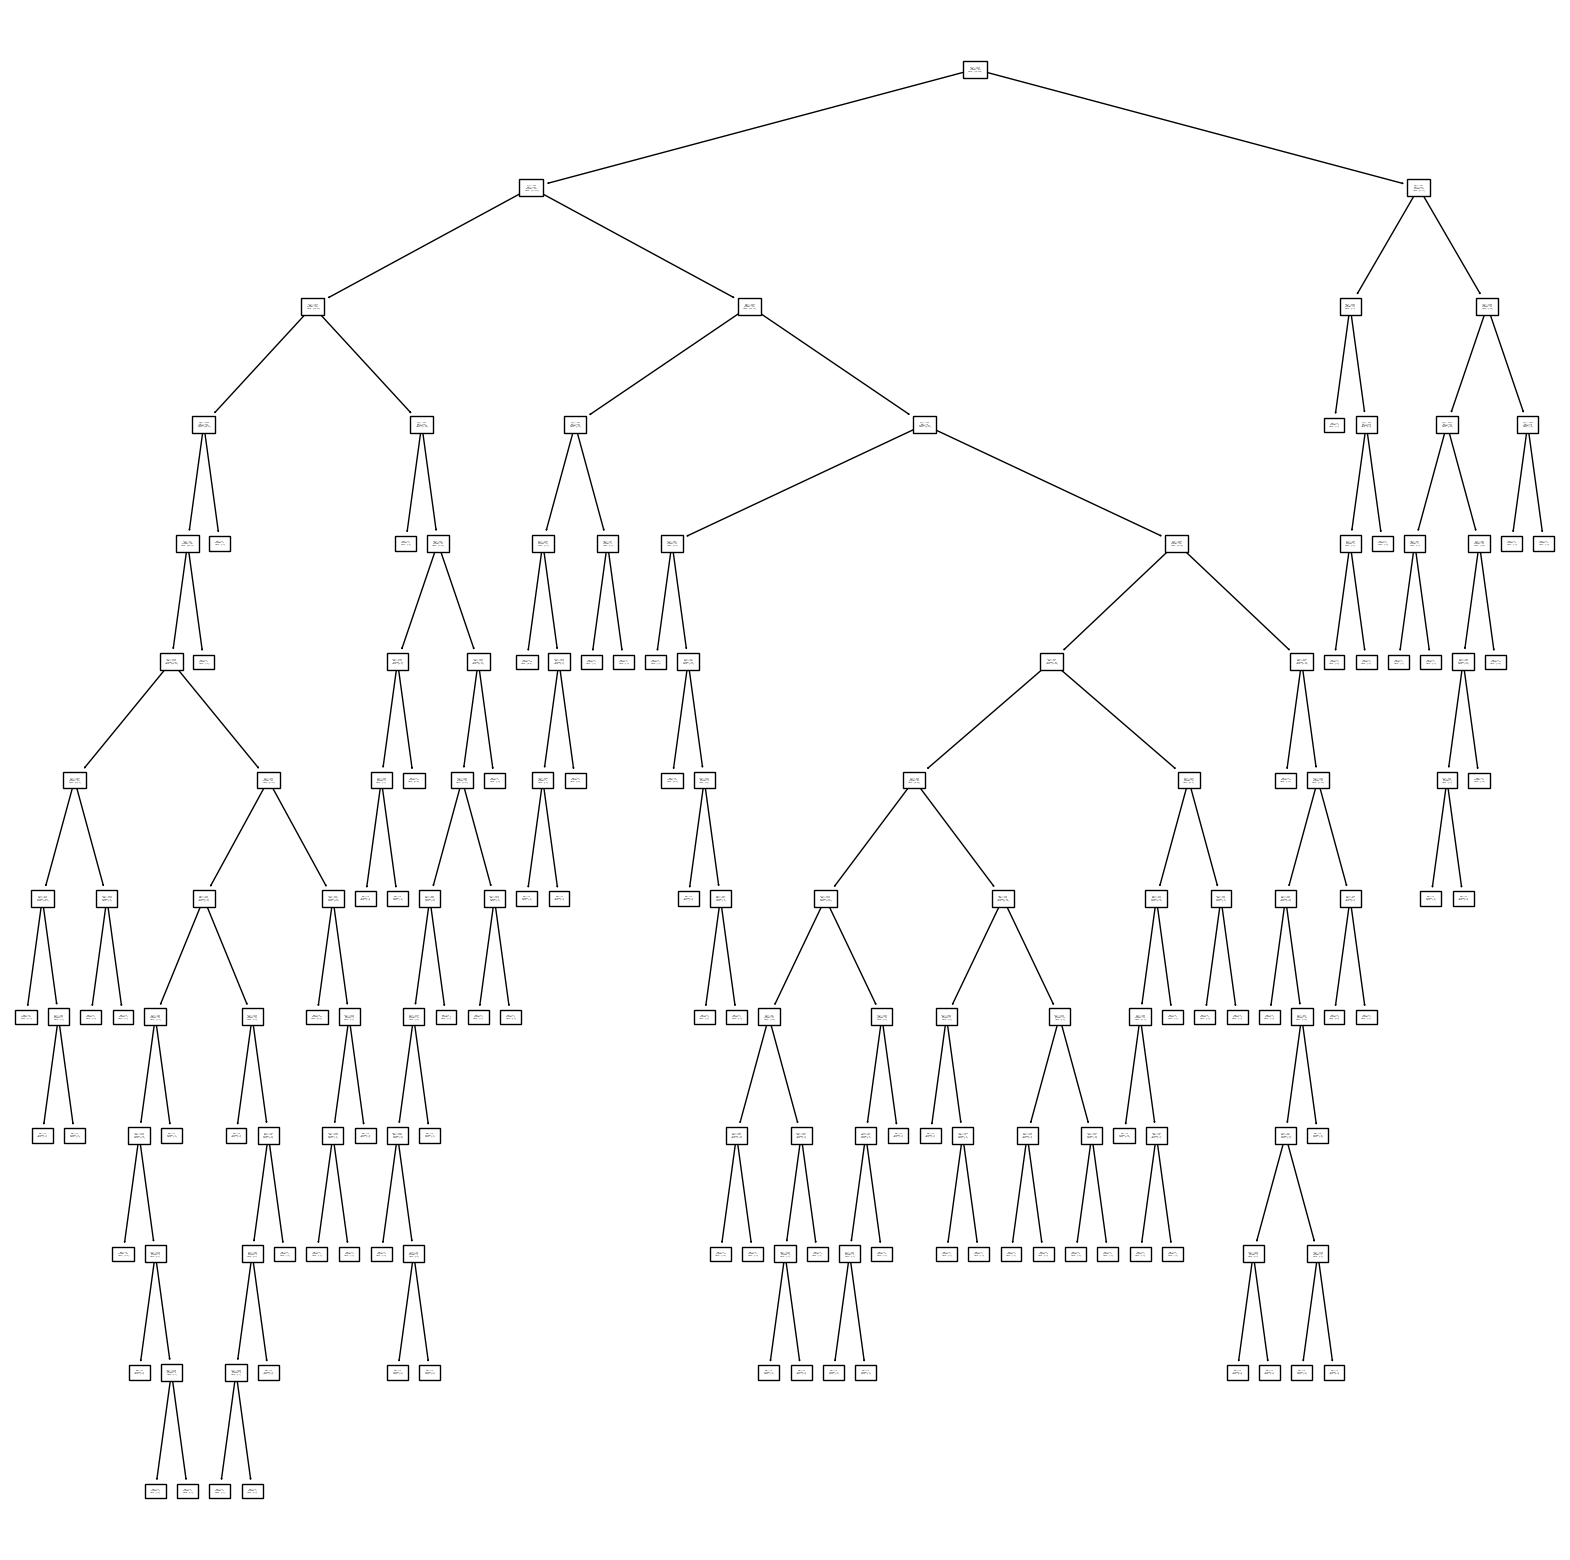

In [65]:
fig, ax = plt.subplots(figsize=(20, 20))

plot_tree(clf, fontsize=1, ax=ax)
plt.show()

In [63]:
param_grid = [
    {'criterion': ['entropy', 'gini']},
    {'splitter' : ['best', 'random']},
    {'max_depth': np.arange(1, 30)},
    {'min_samples_leaf':  np.arange(1, 30)}
]

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=0)

search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring="roc_auc", cv=cv)
search.fit(X_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=0),
             estimator=DecisionTreeClassifier(),
             param_grid=[{'criterion': ['entropy', 'gini']},
                         {'splitter': ['best', 'random']},
                         {'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])},
                         {'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])}],
             scoring='roc_auc')

In [64]:
y_pred = search.predict(X_test)

In [ ]:
roc_auc_score(y_pred, y_test)

## Задание 2. 

Используя данные из файла IceCreamData.csv предскажите количественное значение дохода от продажи мороженного в зависимости от температуры воздуха.  Используйте регрессию на основе дерева принятия решений. Решите эту же задачу, испотзуя полиномиальную регрессию. Сравните качество моделей.

In [46]:
gdd.download_file_from_google_drive(file_id='1ZZWAYvx944ZakDDY_X5--DSo3U3Im8XG',
                                dest_path='./data/IceCreamData.csv')

In [47]:
df =  pd.read_csv('./data/IceCreamData.csv')
df

,Temperature,Revenue
0,24.566884,534.799028
1,26.005191,625.190122
2,27.790554,660.632289
3,20.595335,487.706960
4,11.503498,316.240194
...,...,...
495,22.274899,524.746364
496,32.893092,755.818399
497,12.588157,306.090719
498,22.362402,566.217304


In [48]:
X, y = np.array(df['Temperature']).reshape(-1, 1), df['Revenue']

In [49]:
clf1 =  DecisionTreeRegressor(max_depth=5)
clf2 = make_pipeline(PolynomialFeatures(3), DecisionTreeRegressor(max_depth=5))

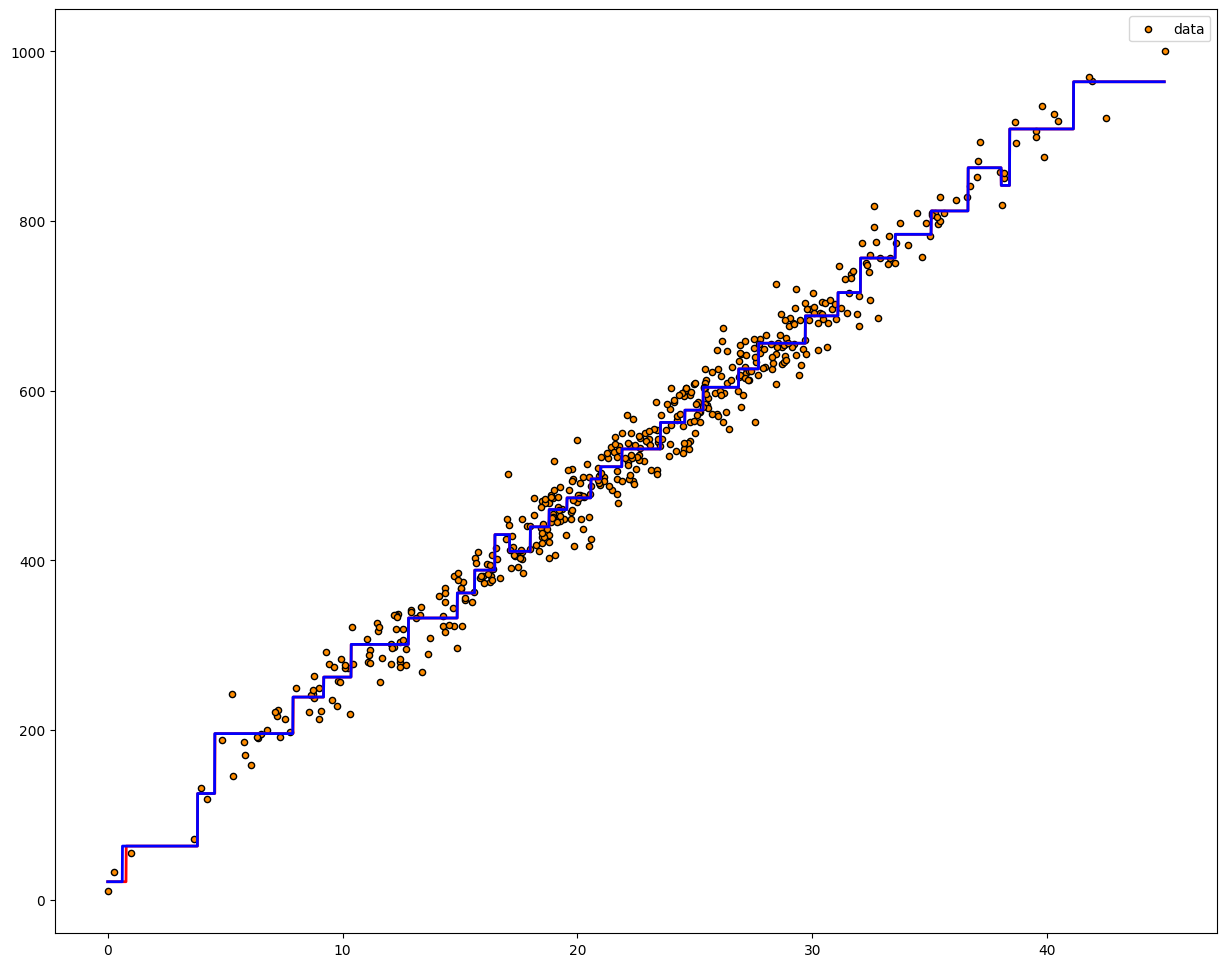

In [50]:
clf1.fit(X, y)
clf2.fit(X, y)

# Predict
X_test = np.arange(df['Temperature'].min(), df['Temperature'].max(), 0.01).reshape(-1, 1)
y_1 = clf1.predict(X_test)
y_2 = clf2.predict(X_test)

# Plot the results
plt.figure(figsize=(15,12))
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test, y_2, color="r", linewidth=2)
plt.plot(X_test, y_1, color="b", linewidth=2)
plt.legend()
plt.show()


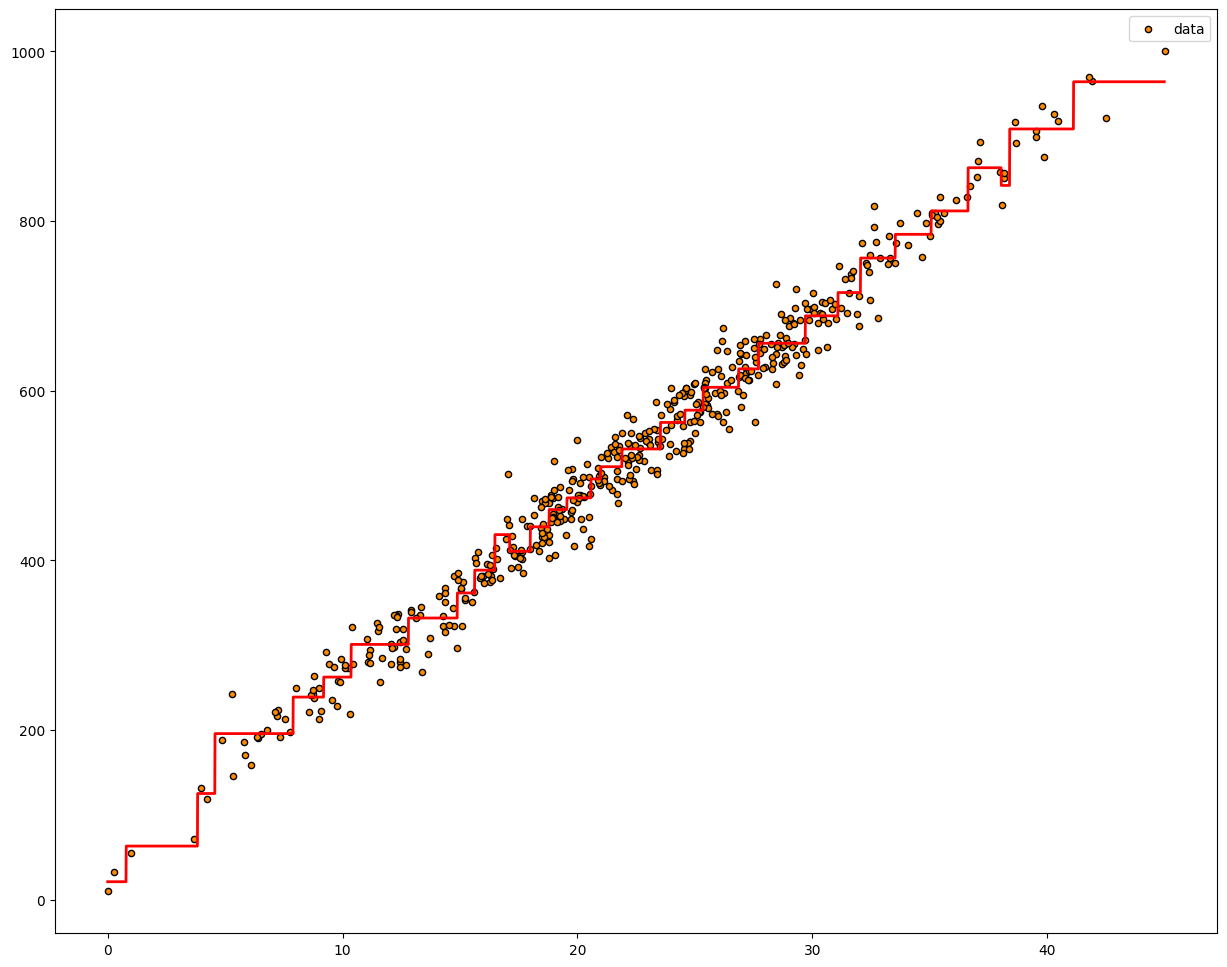

In [51]:
plt.figure(figsize=(15,12))
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test, y_2, color="r", linewidth=2)
plt.legend()
plt.show()

## Ссылки

Классификация.  https://www.kaggle.com/prashant111/decision-tree-classifier-tutorial

Документация.   https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html


Регрессия.  https://www.aionlinecourse.com/tutorial/machine-learning/decision-tree-intuition